(GLM-out-of-sample-predictions)=
# Out-Of-Sample Predictions

:::{post} June, 2022
:tags: generalized linear model, logistic regression, out of sample predictions, patsy
:category: beginner
:::

For many applications we require doing predictions on out-of-sample data. This experiment was motivated by the discussion of the thread ["Out of sample" predictions with the GLM sub-module](https://discourse.pymc.io/t/out-of-sample-predictions-with-the-glm-sub-module/773) on the (great!) forum [discourse.pymc.io/](https://discourse.pymc.io/), thank you all for your input! But note that this GLM sub-module was depricated in favour of [`bambi`](https://github.com/bambinos/bambi). But this notebook implements a 'raw' PyMC model.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import pymc as pm
import seaborn as sns

from scipy.special import expit as inverse_logit
from sklearn.metrics import RocCurveDisplay, accuracy_score, auc, roc_curve
from sklearn.model_selection import train_test_split

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

## Generate Sample Data

We want to fit a logistic regression model where there is a multiplicative interaction between two numerical features.

In [3]:
# Number of data points
n = 250
# Create features
x1 = rng.normal(loc=0.0, scale=2.0, size=n)
x2 = rng.normal(loc=0.0, scale=2.0, size=n)
# Define target variable
intercept = -0.5
beta_x1 = 1
beta_x2 = -1
beta_interaction = 2
z = intercept + beta_x1 * x1 + beta_x2 * x2 + beta_interaction * x1 * x2
p = inverse_logit(z)
# note binimial with n=1 is equal to a bernoulli
y = rng.binomial(n=1, p=p, size=n)
df = pd.DataFrame(dict(x1=x1, x2=x2, y=y))
df.head()

,x1,x2,y
0,-3.207674,0.859021,0
1,0.128200,2.827588,0
2,1.481783,-0.116956,0
3,0.305238,-1.378604,0
4,1.727488,-0.926357,1


Let us do some exploration of the data:

/Users/benjamv/opt/anaconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self.fig.tight_layout(*args, **kwargs)


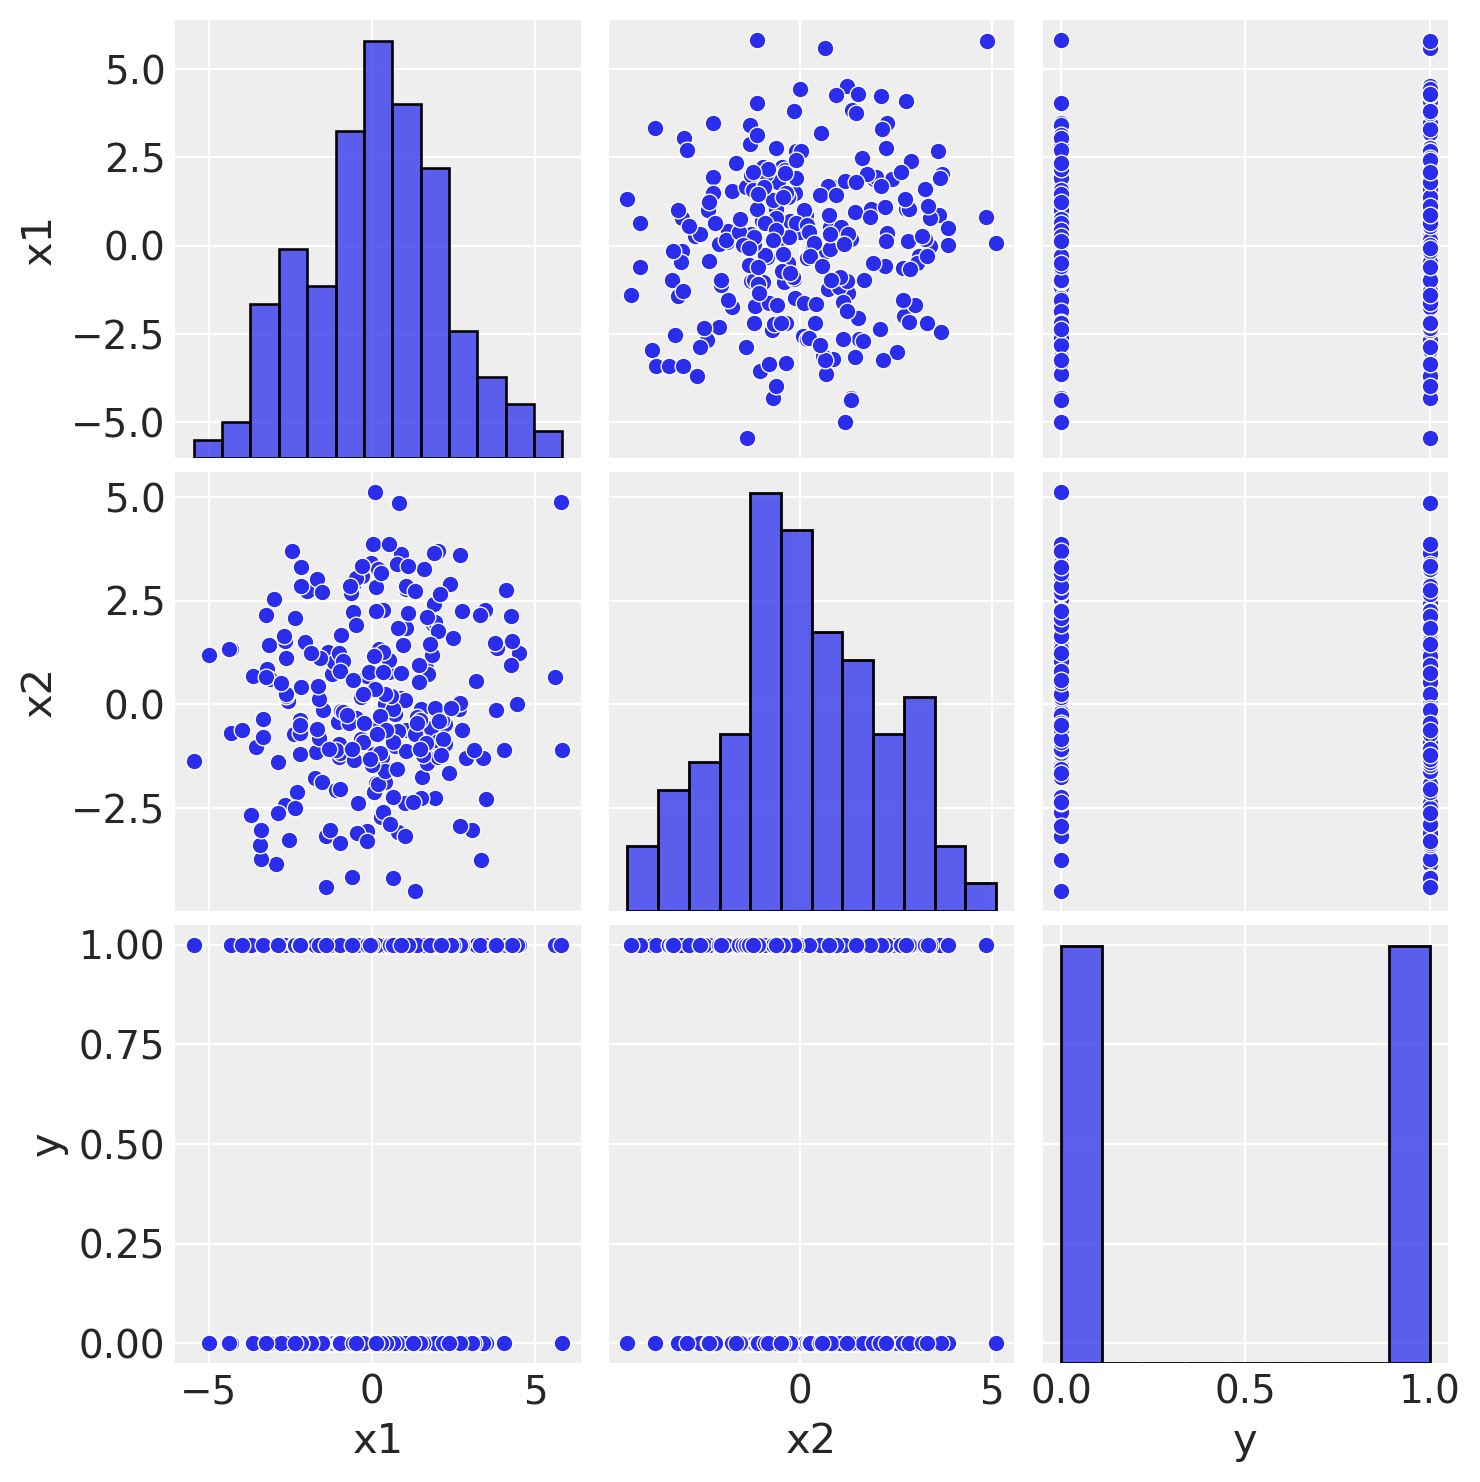

In [4]:
sns.pairplot(data=df, kind="scatter");

- $x_1$ and $x_2$ are not correlated.
- $x_1$ and $x_2$ do not seem to separate the $y$-classes independently.
- The distribution of $y$ is not highly unbalanced.

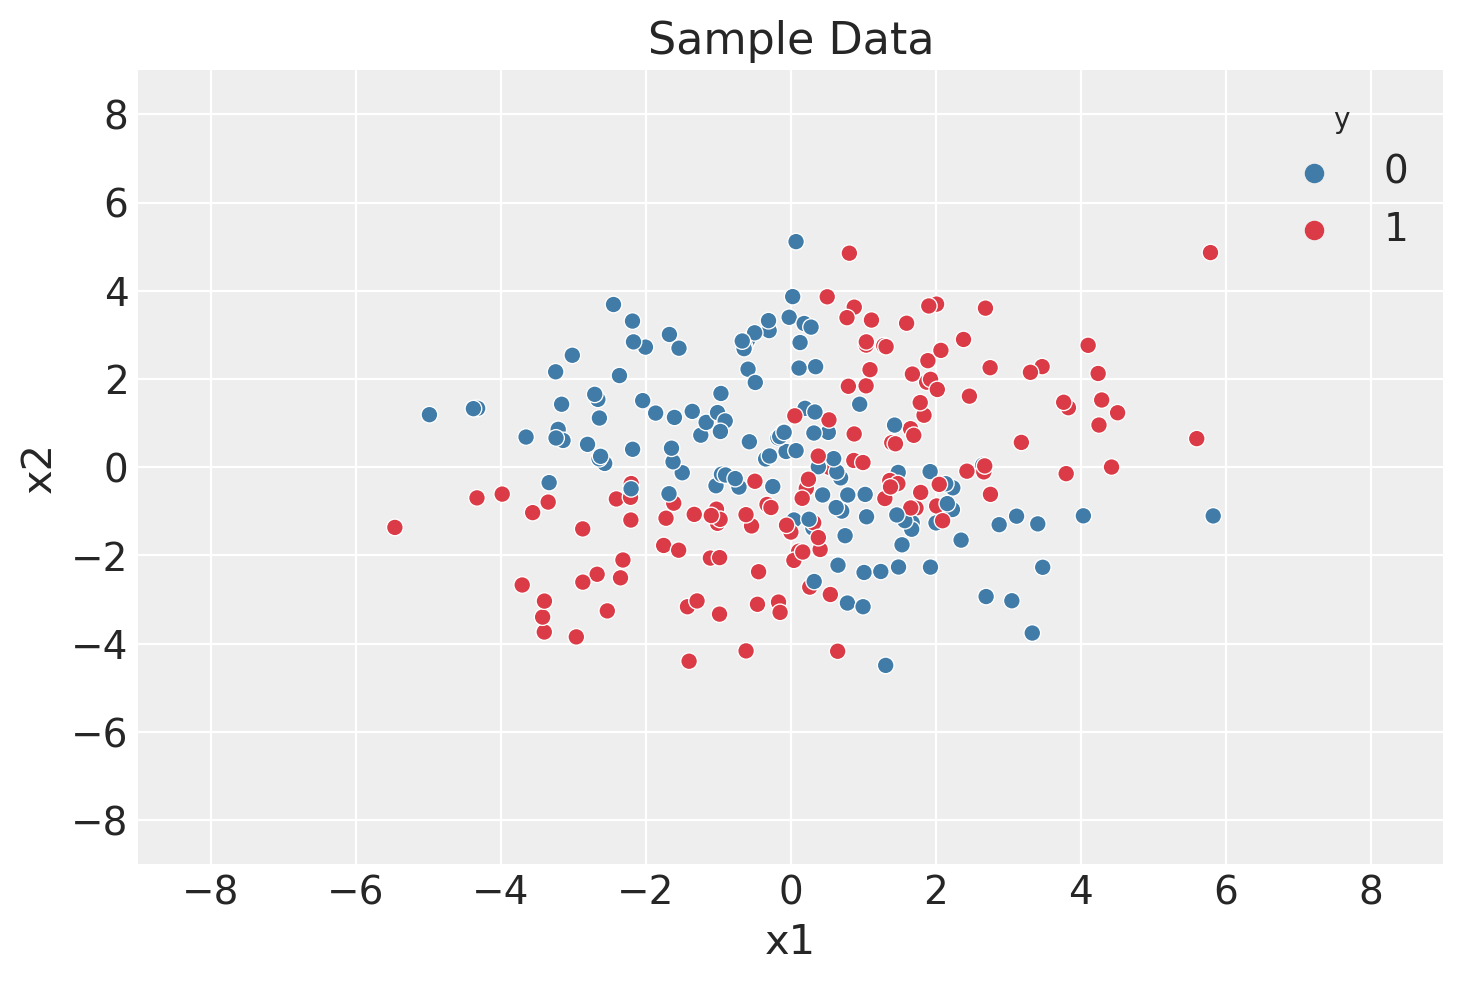

In [5]:
fig, ax = plt.subplots()
sns_c_div = sns.diverging_palette(240, 10, n=2)
sns.scatterplot(x="x1", y="x2", data=df, hue="y", palette=[sns_c_div[0], sns_c_div[-1]])
ax.legend(title="y")
ax.set(title="Sample Data", xlim=(-9, 9), ylim=(-9, 9));

## Prepare Data for Modeling

In [6]:
y, x = patsy.dmatrices("y ~ x1 * x2", data=df)
y = np.asarray(y).flatten()
labels = x.design_info.column_names
x = np.asarray(x)

As pointed out on the [thread](https://discourse.pymc.io/t/out-of-sample-predictions-with-the-glm-sub-module/773) (thank you @Nicky!), we need to keep the labels of the features in the design matrix.

In [7]:
print(f"labels = {labels}")

labels = ['Intercept', 'x1', 'x2', 'x1:x2']


Now we do a train-test split.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)

## Define and Fit the Model

We now specify the model in PyMC.

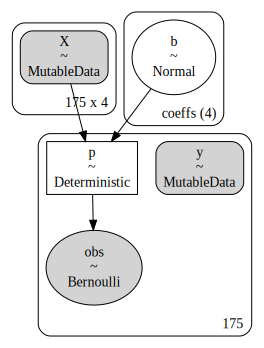

In [9]:
COORDS = {"coeffs": labels}

with pm.Model(coords=COORDS) as model:
    # data containers
    X = pm.MutableData("X", x_train)
    y = pm.MutableData("y", y_train)
    # priors
    b = pm.Normal("b", mu=0, sigma=1, dims="coeffs")
    # linear model
    mu = pm.math.dot(X, b)
    # link function
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Bernoulli("obs", p=p, observed=y)

pm.model_to_graphviz(model)

In [10]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


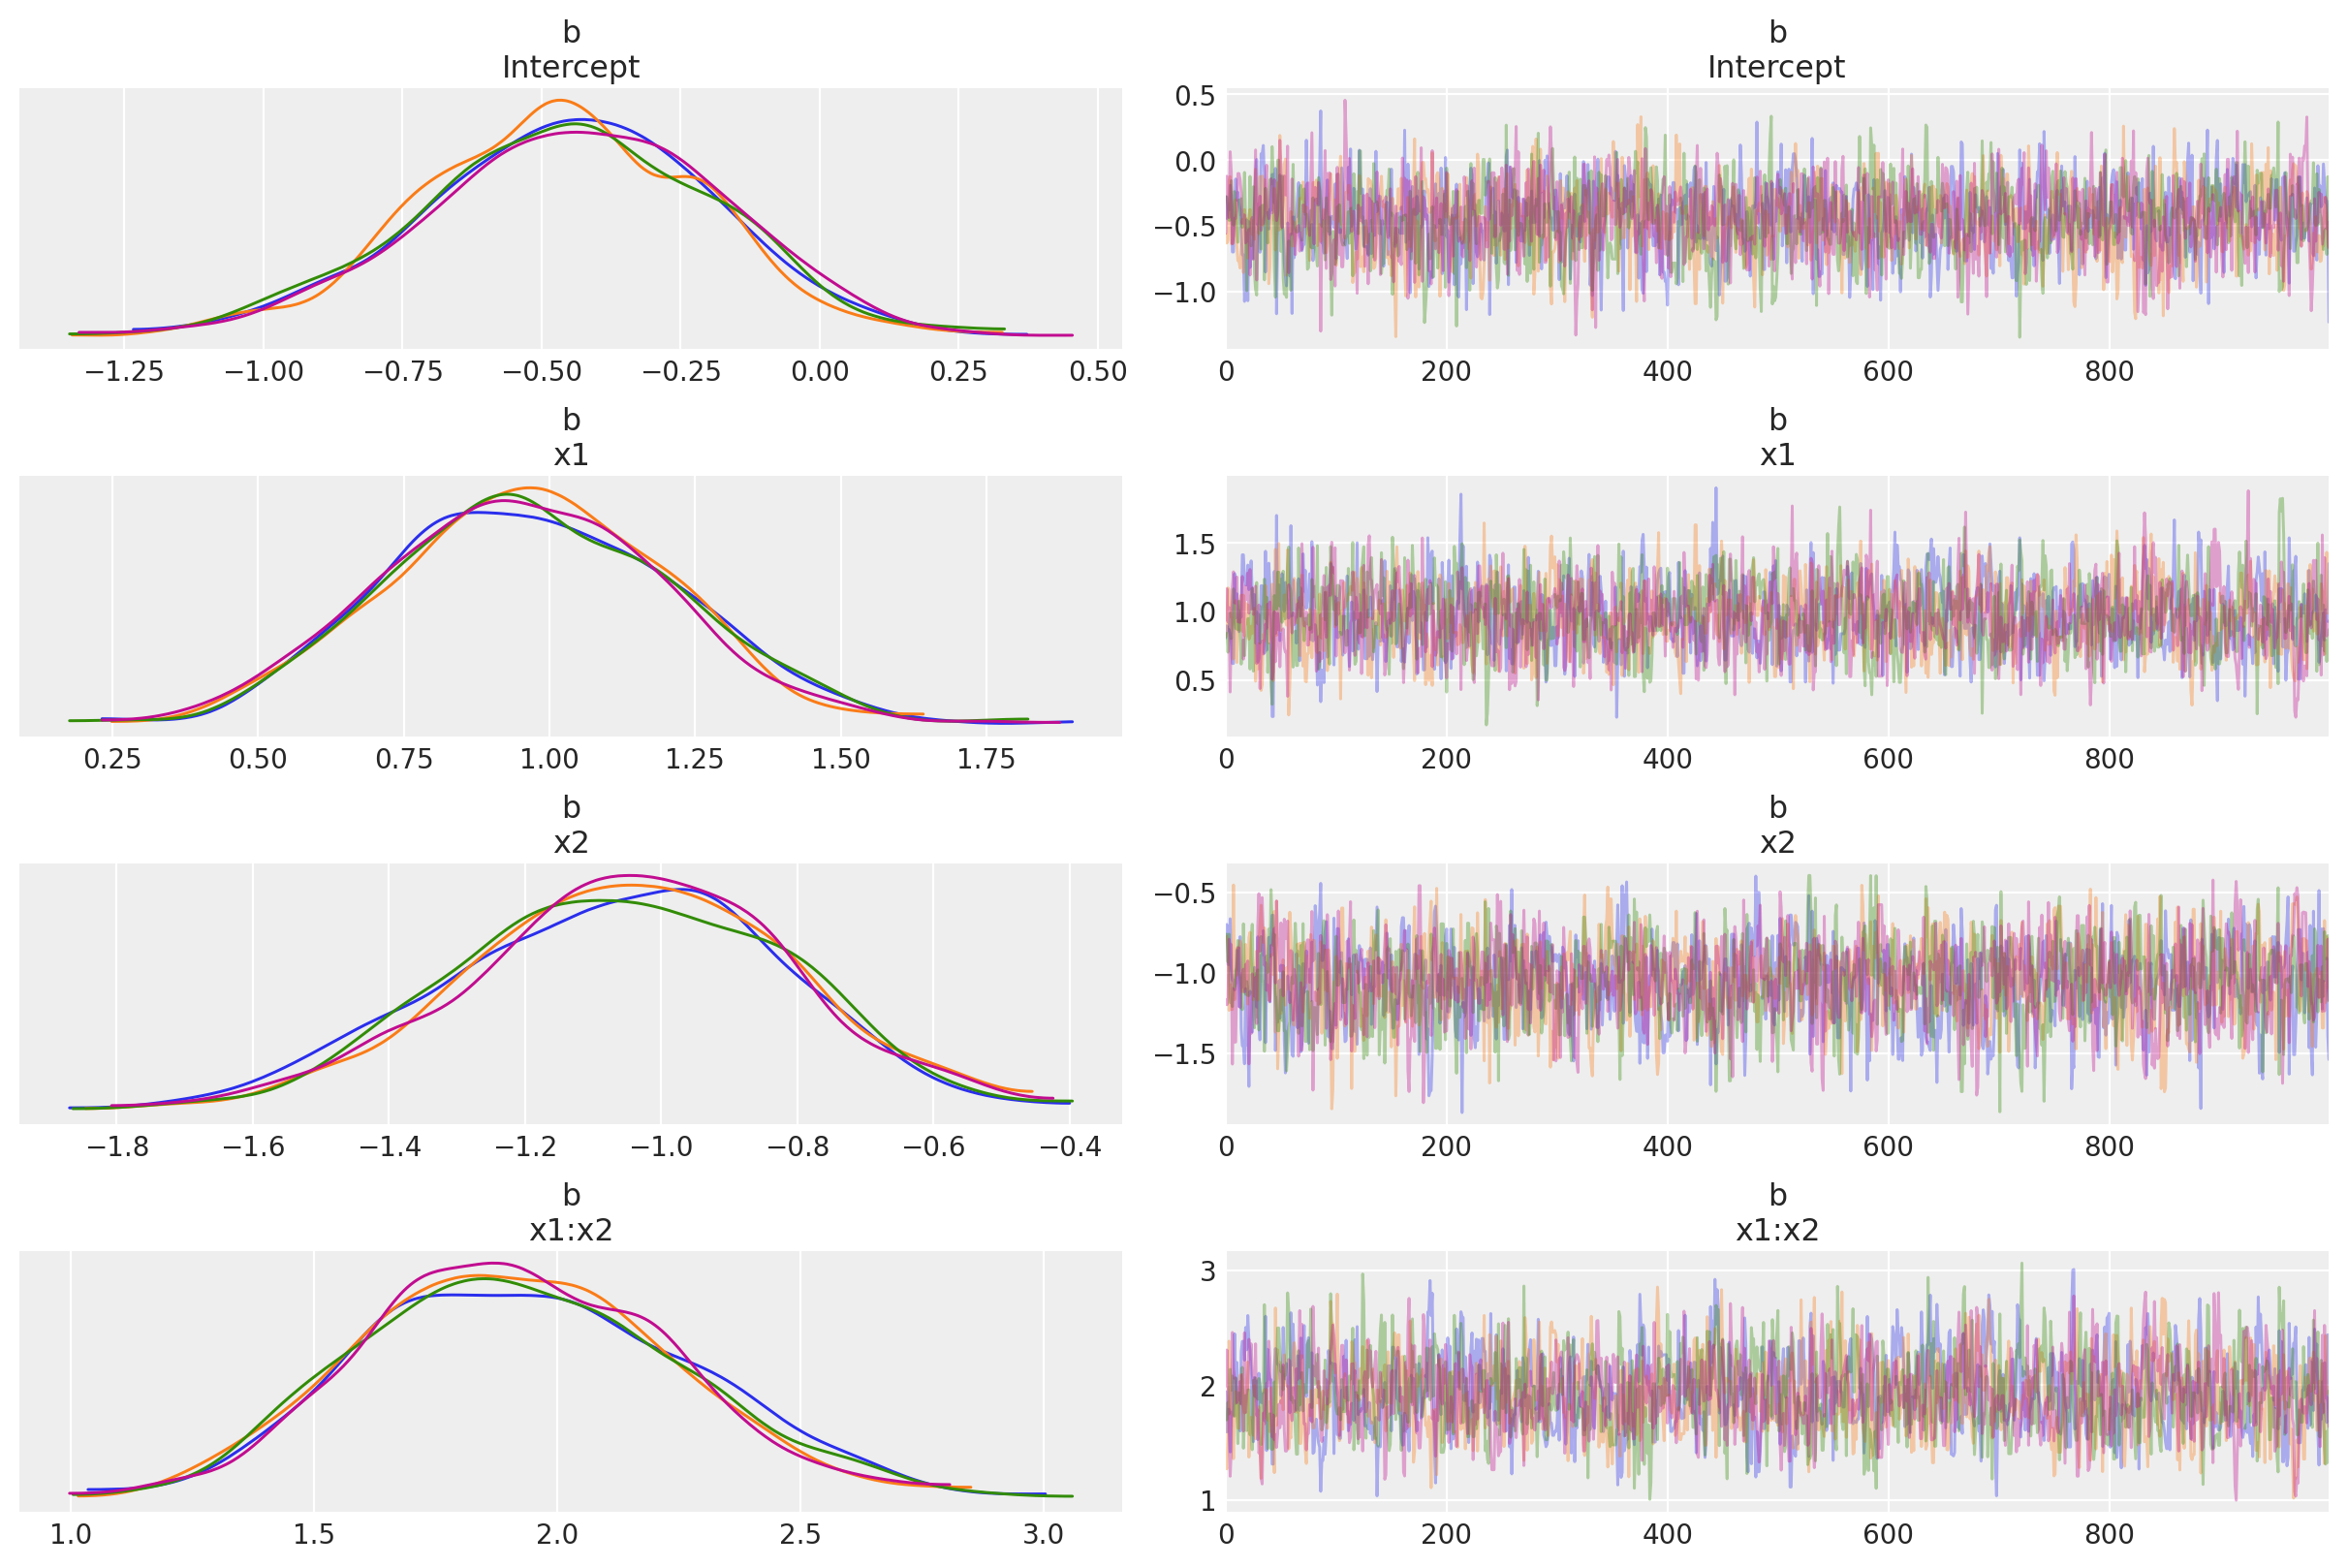

In [11]:
az.plot_trace(idata, var_names="b", compact=False);

The chains look good.

In [12]:
az.summary(idata, var_names="b")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[Intercept],-0.453,0.264,-0.969,0.021,0.006,0.004,2026.0,2420.0,1.0
b[x1],0.964,0.245,0.484,1.388,0.006,0.004,1526.0,2344.0,1.0
b[x2],-1.058,0.243,-1.520,-0.606,0.006,0.004,1569.0,2148.0,1.0
b[x1:x2],1.926,0.328,1.322,2.541,0.009,0.006,1464.0,1962.0,1.0


And we do a good job of recovering the true parameters for this simulated dataset.

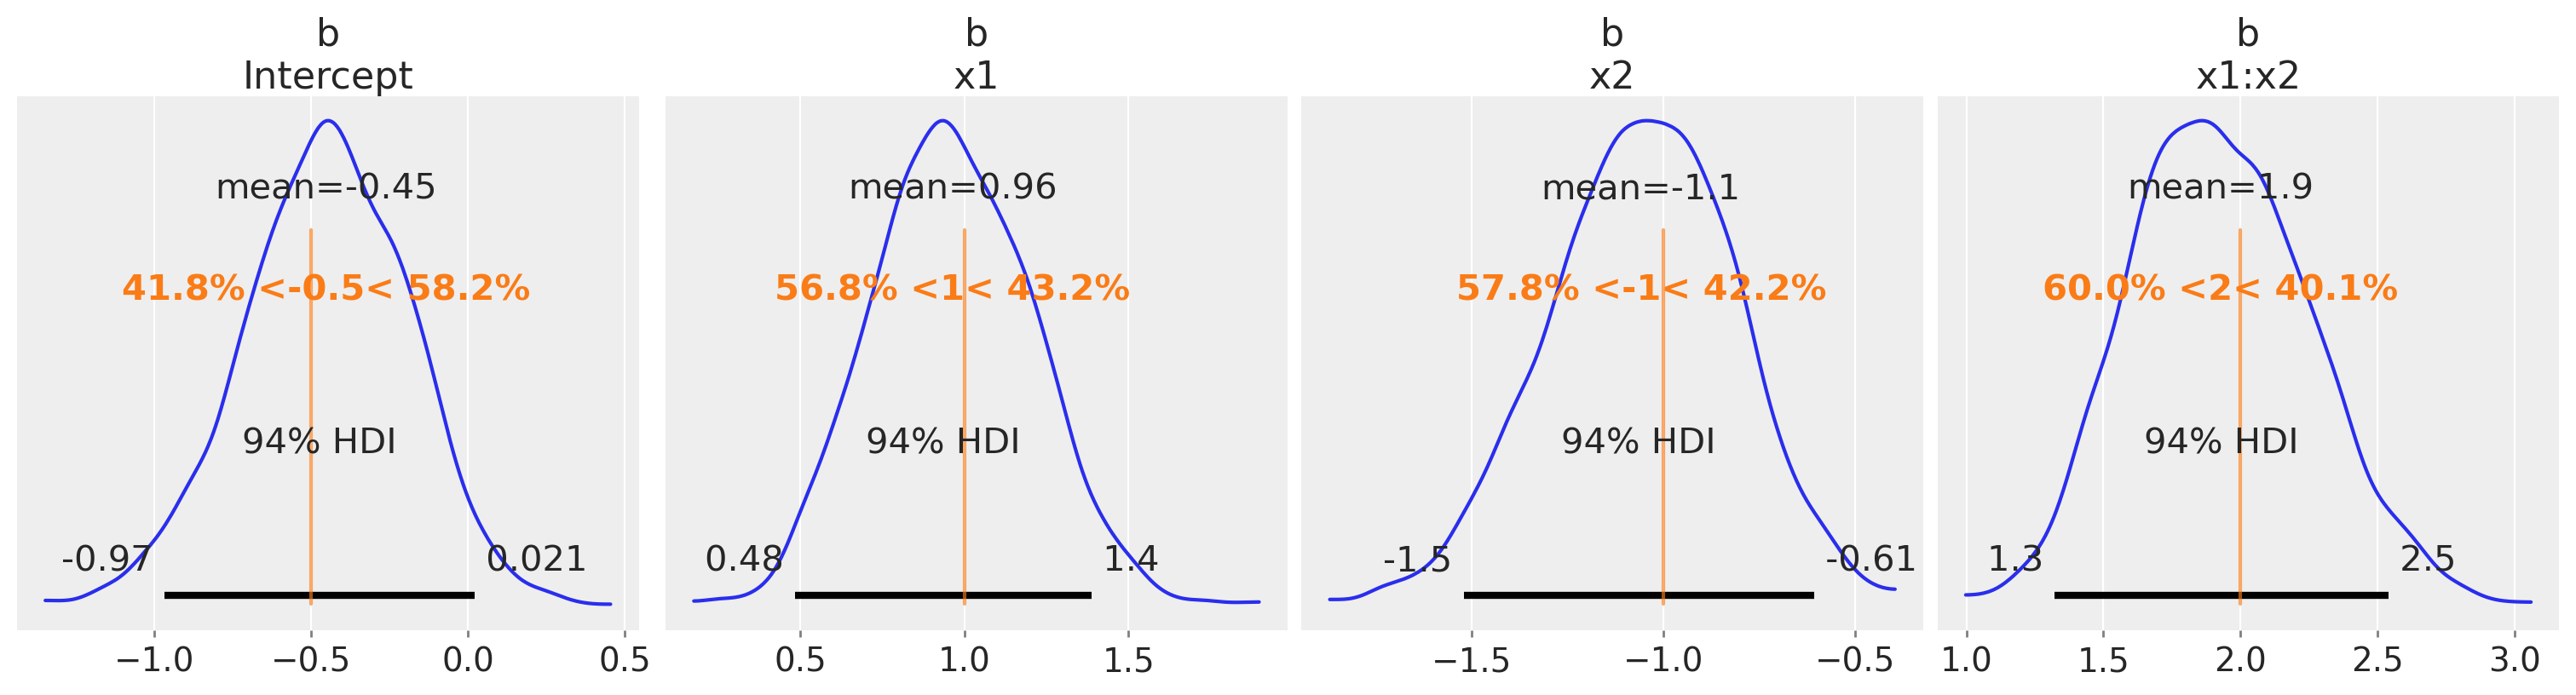

In [13]:
az.plot_posterior(
    idata, var_names=["b"], ref_val=[intercept, beta_x1, beta_x2, beta_interaction], figsize=(15, 4)
);

## Generate Out-Of-Sample Predictions

Now we generate predictions on the test set.

In [14]:
with model:
    pm.set_data({"X": x_test, "y": y_test})
    idata.extend(pm.sample_posterior_predictive(idata))

In [15]:
# Compute the point prediction by taking the mean and defining the category via a threshold.
p_test_pred = idata.posterior_predictive.obs.mean(dim=["chain", "draw"])
y_test_pred = (p_test_pred >= 0.5).astype("int")

## Evaluate Model

First let us compute the accuracy on the test set.

In [16]:
print(f"accuracy = {accuracy_score(y_true=y_test, y_pred=y_test_pred): 0.3f}")

accuracy =  0.893


Next, we plot the [roc curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and compute the [auc](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

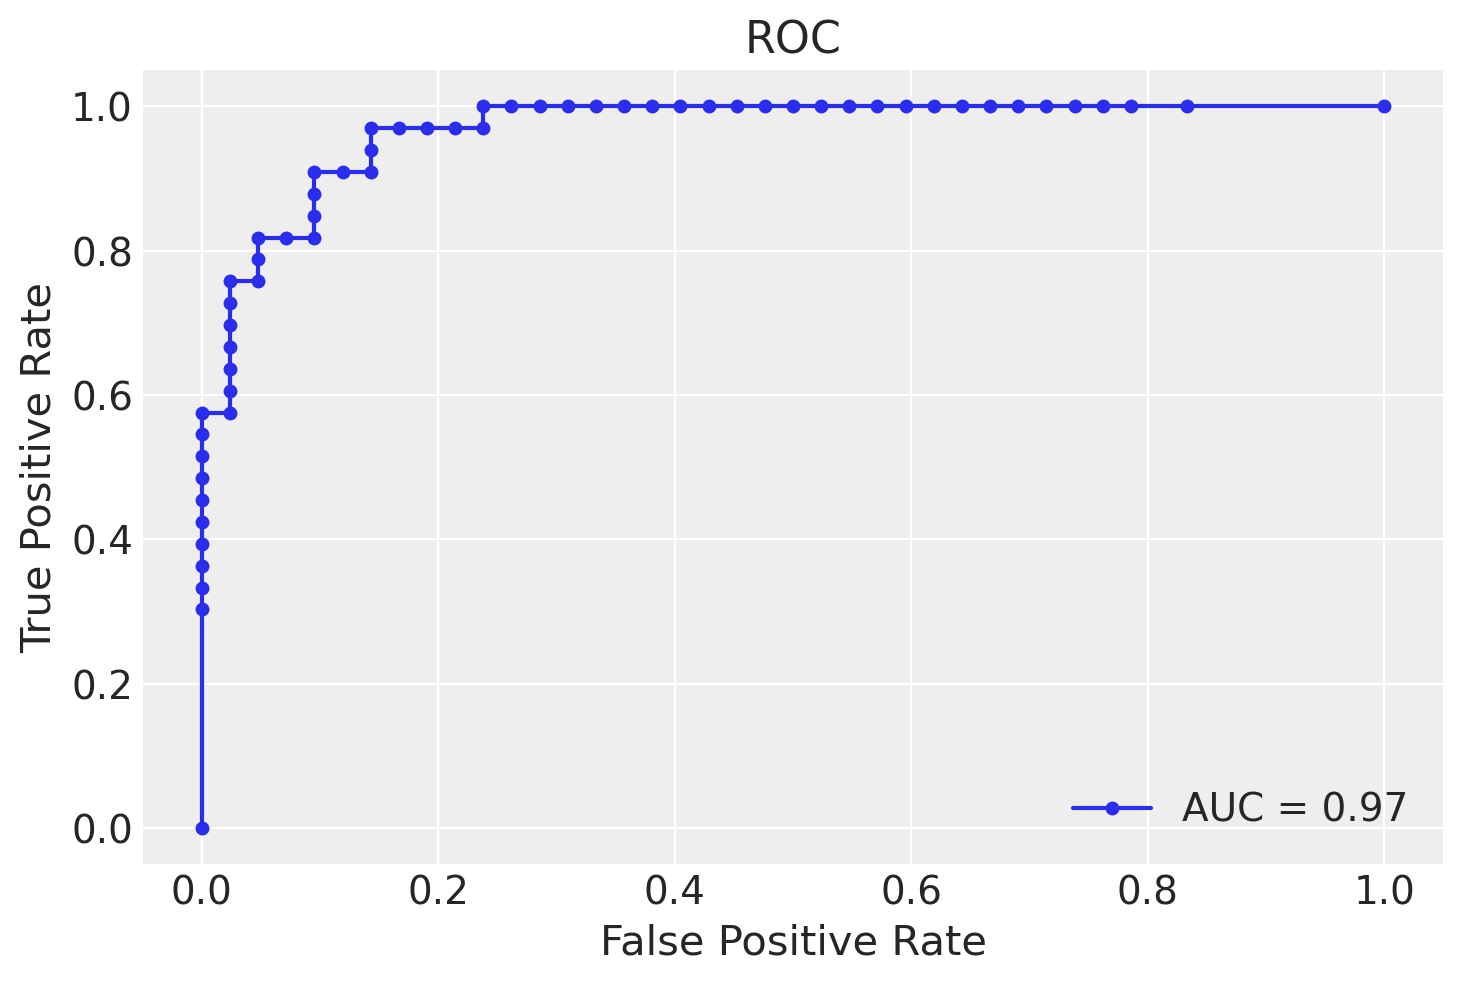

In [17]:
fpr, tpr, thresholds = roc_curve(
    y_true=y_test, y_score=p_test_pred, pos_label=1, drop_intermediate=False
)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
ax.set(title="ROC");

The model is performing as expected (we of course know the data generating process, which is almost never the case in practical applications).

## Model Decision Boundary

Finally we will describe and plot the model decision boundary, which is the space defined as

$$\mathcal{B} = \{(x_1, x_2) \in \mathbb{R}^2 \: | \: p(x_1, x_2) = 0.5\}$$

where $p$ denotes the probability of belonging to the class $y=1$ output by the model. To make this set explicit, we simply write the condition in terms of the model parametrization:

$$0.5 = \frac{1}{1 + \exp(-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_{12} x_1x_2))}$$

which implies

$$0 = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_{12} x_1x_2$$

Solving for $x_2$ we get the formula

$$x_2 = - \frac{\beta_0 + \beta_1 x_1}{\beta_2 + \beta_{12}x_1}$$

Observe that this curve is a hyperbola centered at the singularity point $x_1 = - \beta_2 / \beta_{12}$.

Let us now plot the model decision boundary using a grid:

In [18]:
def make_grid():
    x1_grid = np.linspace(start=-9, stop=9, num=300)
    x2_grid = x1_grid
    x1_mesh, x2_mesh = np.meshgrid(x1_grid, x2_grid)
    x_grid = np.stack(arrays=[x1_mesh.flatten(), x2_mesh.flatten()], axis=1)
    return x1_grid, x2_grid, x_grid


x1_grid, x2_grid, x_grid = make_grid()

with model:
    # Create features on the grid.
    x_grid_ext = patsy.dmatrix(formula_like="x1 * x2", data=dict(x1=x_grid[:, 0], x2=x_grid[:, 1]))
    x_grid_ext = np.asarray(x_grid_ext)
    # set the observed variables
    pm.set_data({"X": x_grid_ext})
    # calculate pushforward values of `p`
    ppc_grid = pm.sample_posterior_predictive(idata, var_names=["p"])

In [19]:
# grid of predictions
grid_df = pd.DataFrame(x_grid, columns=["x1", "x2"])
grid_df["p"] = ppc_grid.posterior_predictive.p.mean(dim=["chain", "draw"])
# grid_df.sort_values("p", inplace=True)
p_grid = grid_df.pivot(index="x2", columns="x1", values="p").to_numpy()

Now we compute the model decision boundary on the grid for visualization purposes.

In [20]:
def calc_decision_boundary(idata, x1_grid):
    # posterior mean of coefficients
    intercept = idata.posterior.b.sel(coeffs="Intercept").mean().data
    x1 = idata.posterior.b.sel(coeffs="x1").mean().data
    x2 = idata.posterior.b.sel(coeffs="x2").mean().data
    x1x2 = idata.posterior.b.sel(coeffs="x1:x2").mean().data
    # decision boundary equation
    return -(intercept + x1 * x1_grid) / (x2 + x1x2 * x1_grid)

We finally get the plot and the predictions on the test set:

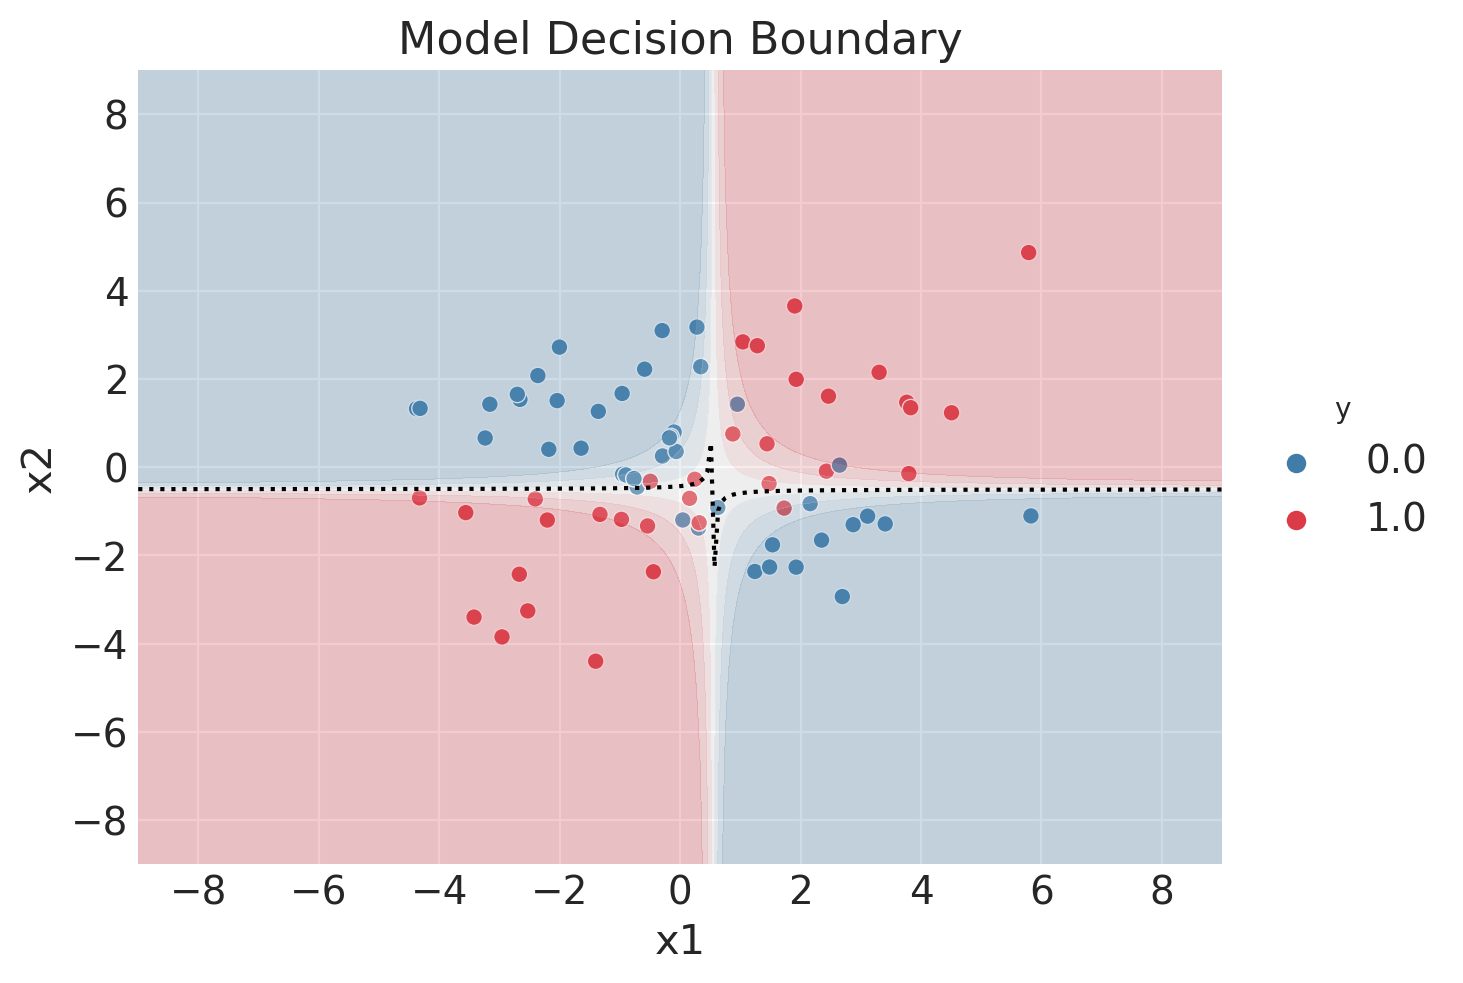

In [21]:
fig, ax = plt.subplots()
cmap = sns.diverging_palette(240, 10, n=50, as_cmap=True)

# data
sns.scatterplot(
    x=x_test[:, 1].flatten(),
    y=x_test[:, 2].flatten(),
    hue=y_test,
    palette=[sns_c_div[0], sns_c_div[-1]],
    ax=ax,
)

# decision boundary
ax.plot(x1_grid, calc_decision_boundary(idata, x1_grid), color="black", linestyle=":")

# grid of predictions
ax.contourf(x1_grid, x2_grid, p_grid, alpha=0.3, cmap=cmap)

ax.legend(title="y", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Model Decision Boundary", xlim=(-9, 9), ylim=(-9, 9), xlabel="x1", ylabel="x2");

**Remark:** Note that we have computed the model decision boundary by using the mean of the posterior samples. However, we can generate a better (and more informative!) plot if we use the complete distribution (similarly for other metrics like accuracy and auc). One way of doing this is by storing and computing it inside the model definition as a `Deterministic` variable as in [Bayesian Analysis with Python (Second edition) - Chapter 4](https://github.com/aloctavodia/BAP/blob/master/code/Chp4/04_Generalizing_linear_models.ipynb).

## References

- [Bambi](https://bambinos.github.io/bambi/), a more complete implementation of the GLM submodule which also allows for mixed-effects models.
- [Bayesian Analysis with Python (Second edition) - Chapter 4](https://github.com/aloctavodia/BAP/blob/master/code/Chp4/04_Generalizing_linear_models.ipynb)
- [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/)

## Authors
- Created by [Juan Orduz](https://github.com/juanitorduz).
- Updated by [Benjamin T. Vincent](https://github.com/drbenvincent) to PyMC v4 in June 2022

## Watermark

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl

Last updated: Sun Jun 05 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.2.0

aesara: 2.6.2
aeppl : 0.0.31

matplotlib: 3.5.1
numpy     : 1.21.6
pymc      : 4.0.0b6
arviz     : 0.12.0
pandas    : 1.4.1
patsy     : 0.5.2
sys       : 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
seaborn   : 0.11.0

Watermark: 2.3.0



:::{include} ../page_footer.md :::